## Assignment: Week 5 Part 2
### Team: Ahm Hamza

## Overview

This project I decided to scrap Reddit and use of supervised machine learning to classify Reddit posts into meaningful categories. Drawing on textual data from three ideologically distinct subreddits r/news, r/conspiracy, and r/science the goal is to train a text classification model that can accurately identify the community origin of unseen Reddit content. Where automated text classification system capable of distinguishing between news articles, conspiracy theories, and scientific content using natural language processing.


In [1]:
pip install -U -q kaleido

In [14]:
import praw
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
from collections import Counter
import warnings
import logging
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
logging.getLogger("praw").setLevel(logging.ERROR)
# download required nltk data
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4') # Added download for omw-1.4

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Collection and Preprocessing

Reddit data was collected using the PRAW (Python Reddit API Wrapper) library. A total of 1,799 posts were initially collected across the three subreddits, with a balanced class distribution:



*   r/conspiracy: 600 posts
*   r/science: 600 posts
*   r/news: 599 posts



In [4]:
# initialize reddit api connection
reddit = praw.Reddit(
    client_id="hyyIqZRK0b0FJA98WveTxQ",
    client_secret="mlzG_7NLvcgmmc2SfURVPnJ9dkgvWw",
    user_agent="windows:reddit.textclassifier:v1.0 (by /u/kab971jam3)"
)

Function fetch_posts() which pulls posts from a specific subreddit using Reddit’s API (via the PRAW library). For each post, I extract the:

* Title and selftext (the main text content)
* Score (upvotes)
* Number of comments


I also label each post to indicate which subreddit it came from ( "science", "news").




In [5]:



def fetch_posts(subreddit_name, label, limit=2000):
    """
    fetch posts from a specific subreddit and assign labels

    args:
        subreddit_name: name of the subreddit to fetch from
        label: classification label to assign to posts
        limit: maximum number of posts to fetch

    returns:
        list of dictionaries containing post data
    """
    subreddit = reddit.subreddit(subreddit_name)
    posts = []

    for post in subreddit.hot(limit=limit):
        if not post.stickied:
            posts.append({
                "title": post.title,
                "selftext": post.selftext,
                "label": label,
                "score": post.score,
                "num_comments": post.num_comments
            })
    return posts


**Scraping Data**:
I use the fetch_posts() function to download 600 posts each from r/worldnews, r/conspiracy, and r/science, giving me a alomst perfectly balanced dataset of 1799 posts.


**Combining Title and Body**:
I combine the title and selftext of each post into a single column called "text" and keep only the relevant columns (text, label, score, num_comments).


**Preprocessing the Text:**
Removes URLs, mentions, and non-alphabet characters
Converts text to lowercase
Tokenizes the text into individual words
Removes stopwords (common but meaningless words like "and", "the", "is")
Lemmatizes words (reduces them to their base form, e.g., "running" → "run")


In [6]:
# fetch data from multiple subreddits for diverse classification
print("scraping data from reddit")

data = []
data += fetch_posts("worldnews", "news", 600)
data += fetch_posts("conspiracy", "conspiracy", 600)
data += fetch_posts("science", "science", 600)

# create dataframe and preprocess text
df = pd.DataFrame(data)
df["text"] = df["title"] + " " + df["selftext"]
df = df[["text", "label", "score", "num_comments"]]
print(f"total posts collected: {len(df)}")
print(f"distribution of labels: {df['label'].value_counts()}")

# initialize lemmatizer and stop_words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# remove empty posts and clean text
def clean_text(text):
    # remove URLs, reddit mentions, non-letters
    text = re.sub(r"http\S+|www\S+|@\S+|[^a-zA-Z\s]", "", text)
    text = text.lower()
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 2]

    return " ".join(words)

df['text'] = df['text'].apply(clean_text)
print(df.head())

scraping data from reddit
total posts collected: 1798
distribution of labels: label
science       600
news          599
conspiracy    599
Name: count, dtype: int64
                                                text label  score  \
0  president volodymyr zelenskyy received politic...  news  15167   
1  donald trump may denied privilege addressing p...  news    936   
2  engine fuel supply cut air india jet crash pre...  news   3944   
3  admiral kuznetsov russia aircraft carrier set ...  news    542   
4  ukrainian mig strike russian military crossing...  news   1902   

   num_comments  
0           229  
1            81  
2           590  
3            52  
4            37  


## Model Training
I split the training and testing sets using an 80/20 ratio while stratifying by label to keep the class distribution balanced. Then  convert the text into numerical features through vectorizaiton, which captures how important a word or phrase is to a specific post relative to the whole corpus. Also, I use Logistic Regression with L2 regularization and class balance to account for any slight class imbalance. This trains a model to predict which subreddit a post came from based on its text content.


In [7]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

# create tfidf vectorizer with optimized parameters
vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.85,
    sublinear_tf=True
)

# transform text data to numerical features
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# train logistic Regression with L2 regularization
model = LogisticRegression(class_weight="balanced", max_iter=1000)
model.fit(X_train_vec, y_train)


# make predictions and evaluate model
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nmodel accuracy: {accuracy:.4f}")
print("\nclassification report:")
print(classification_report(y_test, y_pred))


model accuracy: 0.9278

classification report:
              precision    recall  f1-score   support

  conspiracy       0.95      0.88      0.91       120
        news       0.93      0.93      0.93       120
     science       0.91      0.97      0.94       120

    accuracy                           0.93       360
   macro avg       0.93      0.93      0.93       360
weighted avg       0.93      0.93      0.93       360



## Visualization

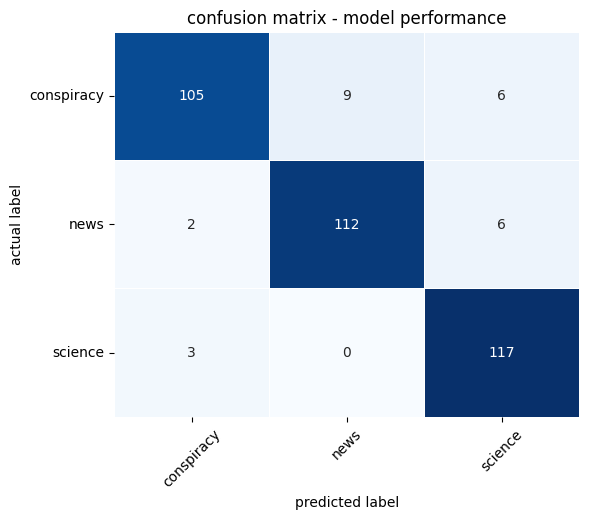

In [8]:

# create confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, labels):
    """create a confusion matrix visualization"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=0.5)

    plt.title('confusion matrix - model performance')
    plt.xlabel('predicted label')
    plt.ylabel('actual label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(y_test, y_pred, ['conspiracy', 'news', 'science'])

generating word cloud comparison...


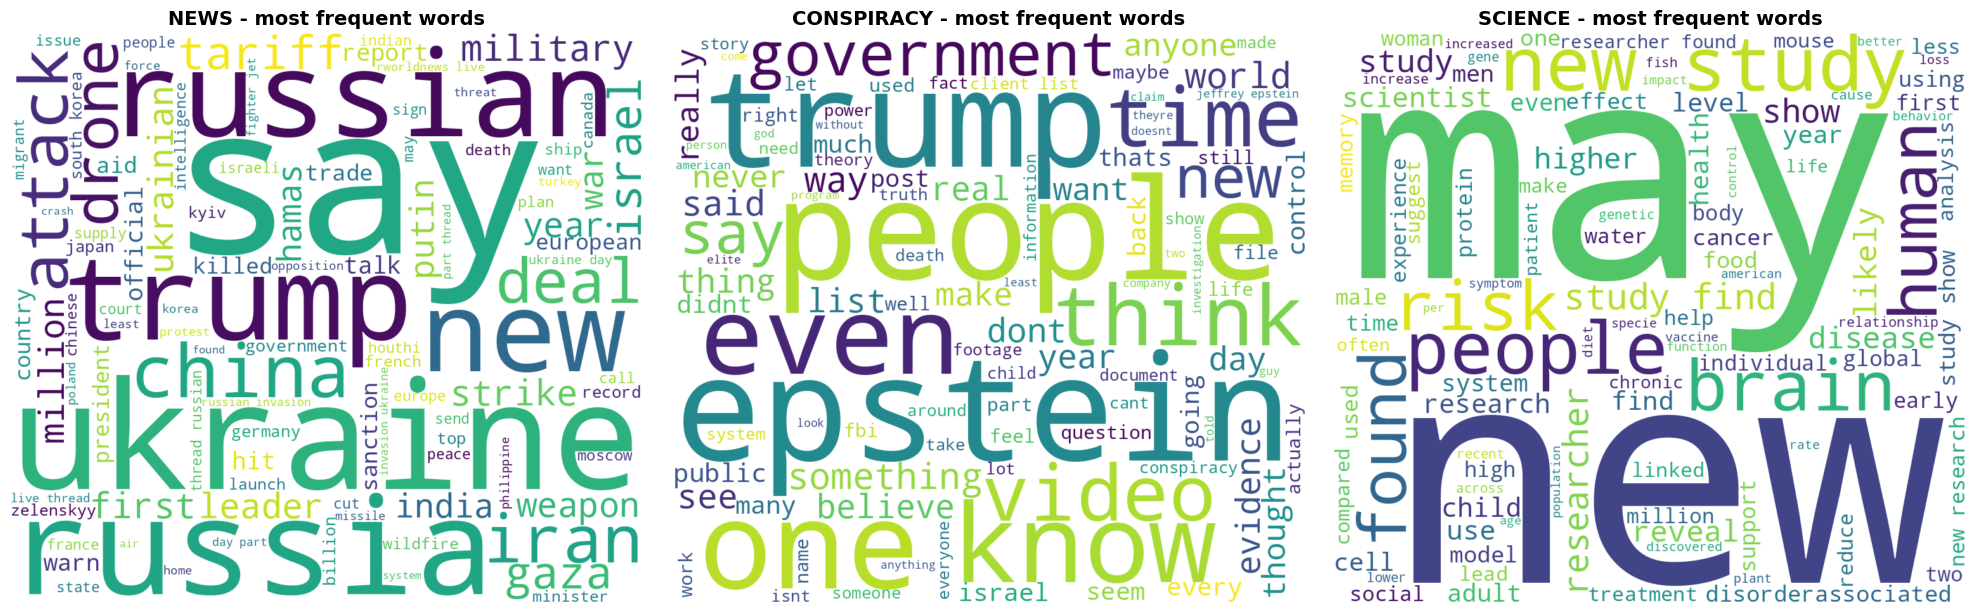

In [9]:
# create word clouds for each category
def create_wordcloud_comparison():
    """generate word clouds for different categories"""
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for i, label in enumerate(['news', 'conspiracy', 'science']):
        # filter text for specific label
        label_text = ' '.join(df[df['label'] == label]['text'].astype(str))

        # create word cloud
        wordcloud = WordCloud(
            width=1000, height=900, background_color='white', colormap='viridis', max_words=100).generate(label_text)

        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{label.upper()} - most frequent words', fontsize=14, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("generating word cloud comparison...")
create_wordcloud_comparison()

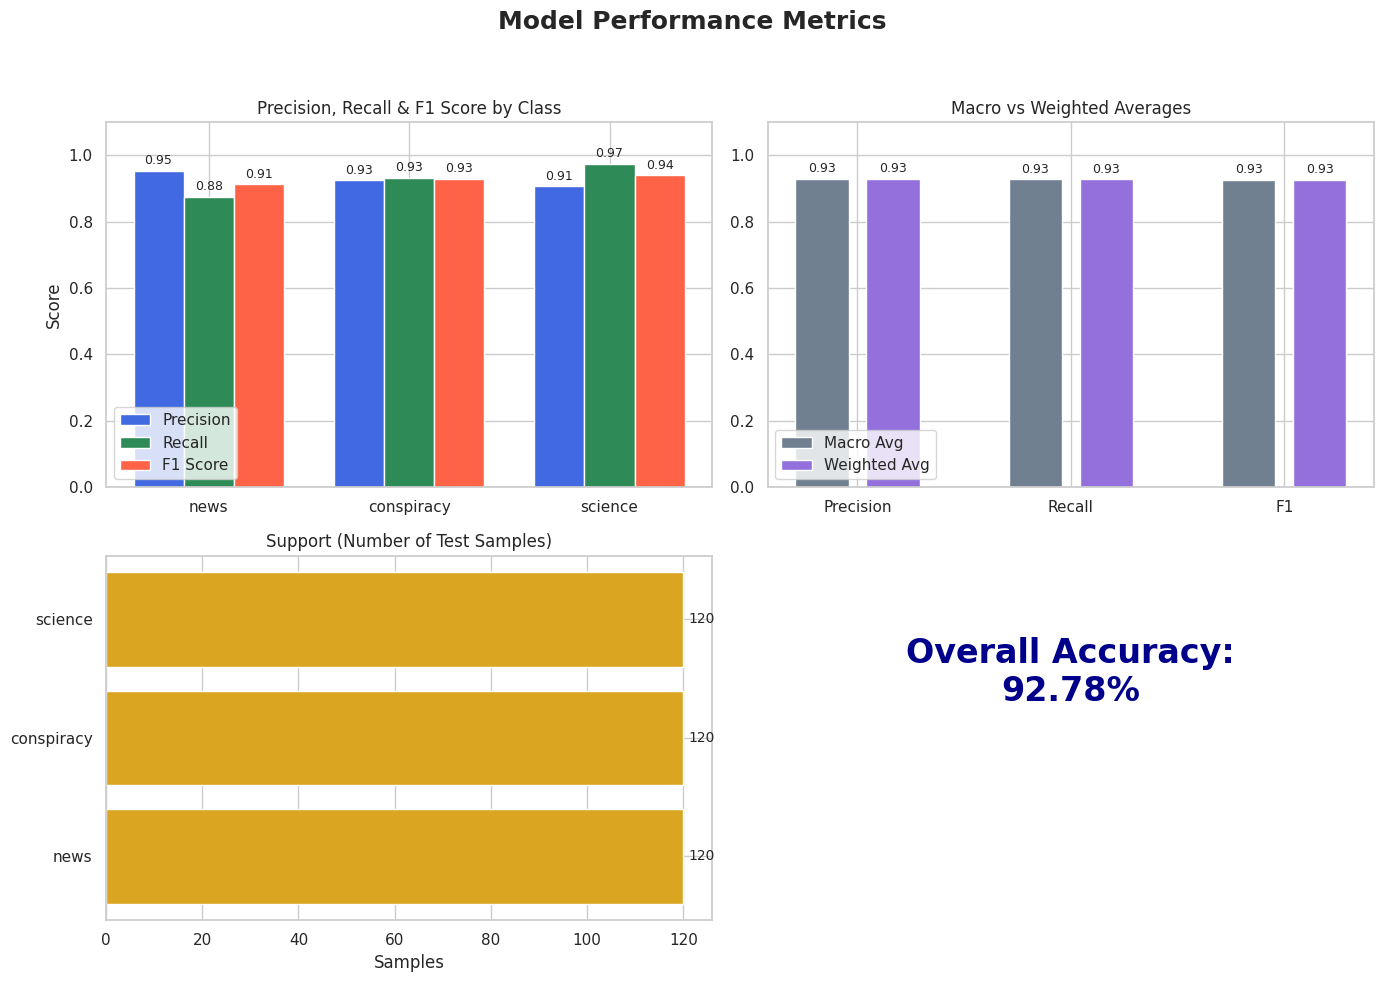

In [28]:
# model performance metrics visualization
def plot_performance_metrics():
    """create aesthetic model performance visualization using matplotlib and seaborn"""

    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    labels = ['news', 'conspiracy', 'science']
    acc = accuracy_score(y_test, y_pred)

    # Averages for annotations
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    p_weighted, r_weighted, f1_weighted, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Set style
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Model Performance Metrics", fontsize=18, fontweight='bold')

    # --- Precision, Recall, F1 (Grouped bar plot) ---
    x = np.arange(len(labels))
    width = 0.25

    axs[0, 0].bar(x - width, precision, width, label='Precision', color='royalblue')
    axs[0, 0].bar(x, recall, width, label='Recall', color='seagreen')
    axs[0, 0].bar(x + width, f1, width, label='F1 Score', color='tomato')

    axs[0, 0].set_title('Precision, Recall & F1 Score by Class')
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(labels)
    axs[0, 0].set_ylim(0, 1.1)
    axs[0, 0].legend()
    axs[0, 0].set_ylabel("Score")
    for i in range(len(labels)):
        axs[0, 0].text(x[i] - width, precision[i] + 0.02, f"{precision[i]:.2f}", ha='center', fontsize=9)
        axs[0, 0].text(x[i], recall[i] + 0.02, f"{recall[i]:.2f}", ha='center', fontsize=9)
        axs[0, 0].text(x[i] + width, f1[i] + 0.02, f"{f1[i]:.2f}", ha='center', fontsize=9)

    # macro vs Weighted Averages ---
    avg_labels = ['Precision', 'Recall', 'F1']
    macro_scores = [p_macro, r_macro, f1_macro]
    weighted_scores = [p_weighted, r_weighted, f1_weighted]

    x2 = np.arange(len(avg_labels))
    axs[0, 1].bar(x2 - width/1.5, macro_scores, width, label='Macro Avg', color='slategray')
    axs[0, 1].bar(x2 + width/1.5, weighted_scores, width, label='Weighted Avg', color='mediumpurple')

    axs[0, 1].set_title('Macro vs Weighted Averages')
    axs[0, 1].set_xticks(x2)
    axs[0, 1].set_xticklabels(avg_labels)
    axs[0, 1].set_ylim(0, 1.1)
    axs[0, 1].legend()
    for i in range(len(avg_labels)):
        axs[0, 1].text(x2[i] - width/1.5, macro_scores[i] + 0.02, f"{macro_scores[i]:.2f}", ha='center', fontsize=9)
        axs[0, 1].text(x2[i] + width/1.5, weighted_scores[i] + 0.02, f"{weighted_scores[i]:.2f}", ha='center', fontsize=9)

    # support per class ---
    axs[1, 0].barh(labels, support, color='goldenrod')
    axs[1, 0].set_title("Support (Number of Test Samples)")
    axs[1, 0].set_xlabel("Samples")
    for i, val in enumerate(support):
        axs[1, 0].text(val + 1, i, str(val), va='center', fontsize=10)

    # --- Accuracy subplot
    axs[1, 1].axis('off')
    axs[1, 1].text(0.5, 0.6, f"Overall Accuracy:\n{acc:.2%}",
                   fontsize=24, color="darkblue", ha='center', fontweight='bold')
    axs[1, 1].text(0.5, 0.3, f"", fontsize=14, ha='center', color='gray')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_performance_metrics()





## Test Section By Examples

In [29]:
# comprehensive test examples with diverse content
test_docs = [
    # news examples
    "breaking news: new covid variant detected in several countries",
    "stock market reaches new high as tech companies report strong earnings",
    "climate change conference reaches historic agreement on emissions",
    "election results show unexpected victory for opposition party",
    "natural disaster strikes coastal region, thousands evacuated",
    "international trade negotiations reach breakthrough agreement",
    "unemployment rate drops to lowest level in five years",
    "new policy announced to address housing crisis in major cities",

    # conspiracy examples
    "the government is hiding the truth about ufos and alien contact",
    "big pharma is suppressing natural cures to maintain profits",
    "chemtrails are being used for mind control by secret organizations",
    "the moon landing was faked in a hollywood studio",
    "secret society controls world governments from the shadows",
    "vaccines contain microchips for population surveillance",
    "mainstream media is controlled by powerful elite groups",
    "9/11 was an inside job to justify war and surveillance",

    # science examples
    "new research reveals how crispr can treat genetic diseases",
    "quantum computing breakthrough could revolutionize encryption",
    "study shows how artificial intelligence can predict protein folding",
    "researchers discover new species of bacteria in deep ocean",
    "breakthrough in fusion energy brings us closer to clean power",
    "new telescope images reveal formation of distant galaxies",
    "study finds link between gut microbiome and mental health",
    "artificial neural networks mimic human brain processing",

    # edge cases and mixed content
    "scientists discover evidence of ancient alien civilization",
    "government funds research into conspiracy theory claims",
    "new study reveals covid origins may be different than reported",
    "ai technology used to predict election outcomes raises concerns",
    "climate scientists face threats from conspiracy theorists",
    "peer review process questioned after controversial study published"
]

In [30]:
# function to make predictions with confidence scores
def predict_with_confidence(text_list):
    """
    predict class labels with confidence scores for given text

    args:
        text_list: list of text documents to classify

    returns:
        dataframe with predictions and confidence scores
    """
    # transform text to features
    X_test_new = vectorizer.transform(text_list)

    # get predictions and probabilities
    predictions = model.predict(X_test_new)
    probabilities = model.predict_proba(X_test_new)

    # create results dataframe
    results = []
    for i, text in enumerate(text_list):
        max_prob = np.max(probabilities[i])
        results.append({
            'text': text[:50] + '...' if len(text) > 50 else text,
            'predicted_class': predictions[i],
            'confidence': max_prob,
            'news_prob': probabilities[i][list(model.classes_).index('news')],
            'conspiracy_prob': probabilities[i][list(model.classes_).index('conspiracy')],
            'science_prob': probabilities[i][list(model.classes_).index('science')]
        })

    return pd.DataFrame(results)



In [31]:
# run comprehensive testing

results_df = predict_with_confidence(test_docs)

# display results with formatting
for i, row in results_df.iterrows():
    print(f"\ntest {i+1}:")
    print(f"text: {row['text']}")
    print(f"predicted: {row['predicted_class'].upper()} (confidence: {row['confidence']:.3f})")
    print(f"probabilities -> news: {row['news_prob']:.3f}, conspiracy: {row['conspiracy_prob']:.3f}, science: {row['science_prob']:.3f}")
    print("-" * 50)


test 1:
text: breaking news: new covid variant detected in sever...
predicted: SCIENCE (confidence: 0.473)
probabilities -> news: 0.237, conspiracy: 0.290, science: 0.473
--------------------------------------------------

test 2:
text: stock market reaches new high as tech companies re...
predicted: SCIENCE (confidence: 0.479)
probabilities -> news: 0.347, conspiracy: 0.174, science: 0.479
--------------------------------------------------

test 3:
text: climate change conference reaches historic agreeme...
predicted: NEWS (confidence: 0.412)
probabilities -> news: 0.412, conspiracy: 0.210, science: 0.379
--------------------------------------------------

test 4:
text: election results show unexpected victory for oppos...
predicted: NEWS (confidence: 0.524)
probabilities -> news: 0.524, conspiracy: 0.193, science: 0.283
--------------------------------------------------

test 5:
text: natural disaster strikes coastal region, thousands...
predicted: NEWS (confidence: 0.383)
probabili

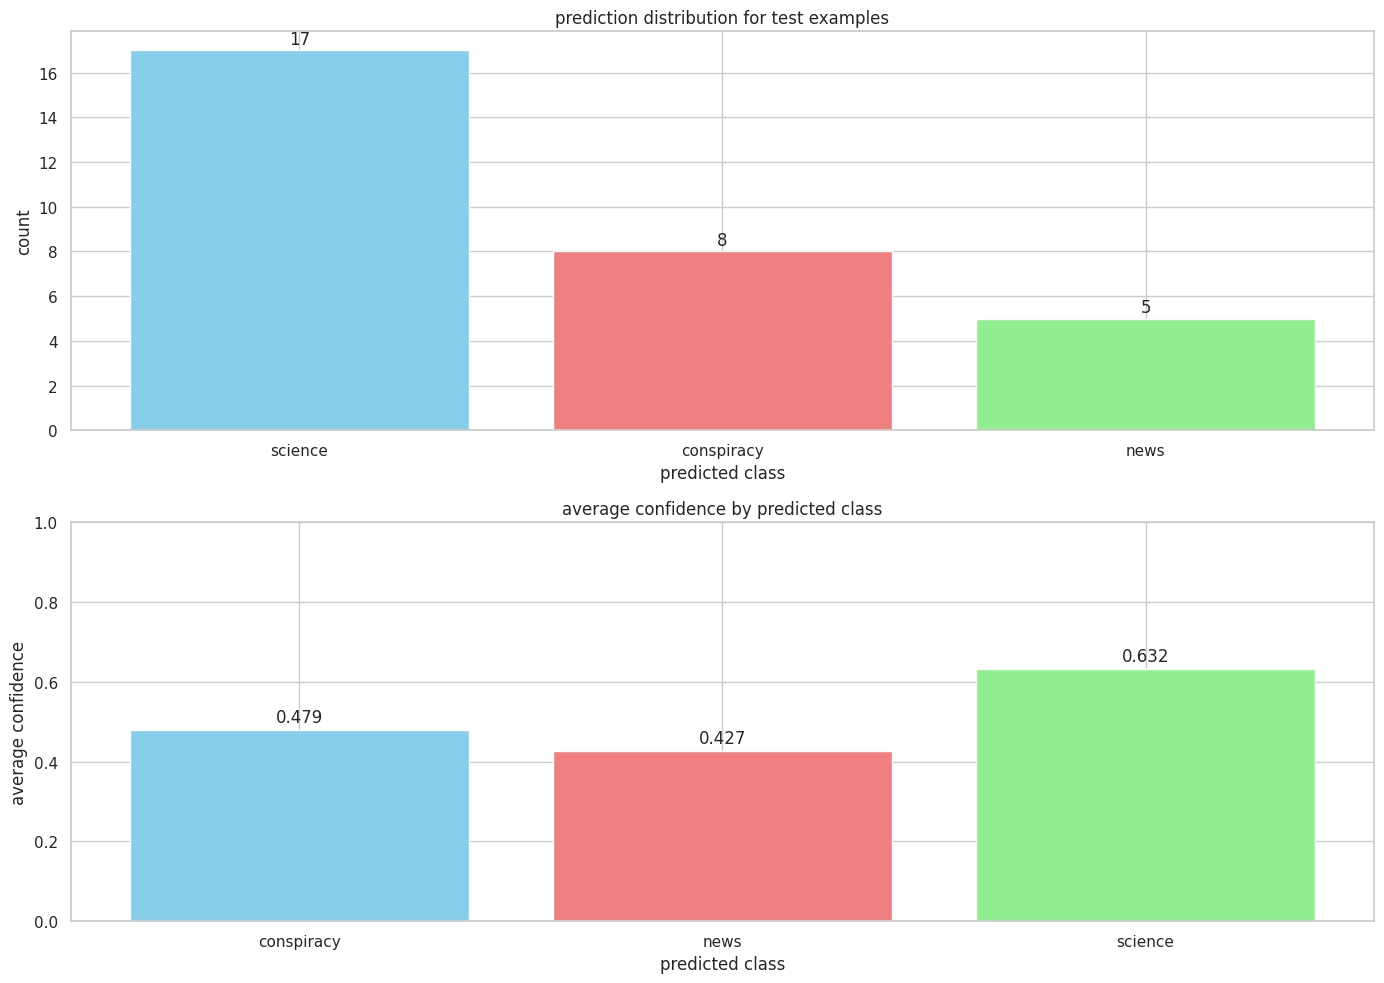

In [32]:
# create visualization of test results
def plot_test_results():
    """visualize comprehensive test results"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # plot 1: prediction distribution
    pred_counts = results_df['predicted_class'].value_counts()
    ax1.bar(pred_counts.index, pred_counts.values, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax1.set_title('prediction distribution for test examples')
    ax1.set_xlabel('predicted class')
    ax1.set_ylabel('count')

    # add count labels on bars
    for i, v in enumerate(pred_counts.values):
        ax1.text(i, v + 0.1, str(v), ha='center', va='bottom')

    # plot 2: confidence score distribution
    confidence_by_class = results_df.groupby('predicted_class')['confidence'].mean()
    ax2.bar(confidence_by_class.index, confidence_by_class.values, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax2.set_title('average confidence by predicted class')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('average confidence')
    ax2.set_ylim(0, 1)

    # add confidence labels
    for i, v in enumerate(confidence_by_class.values):
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
plot_test_results()


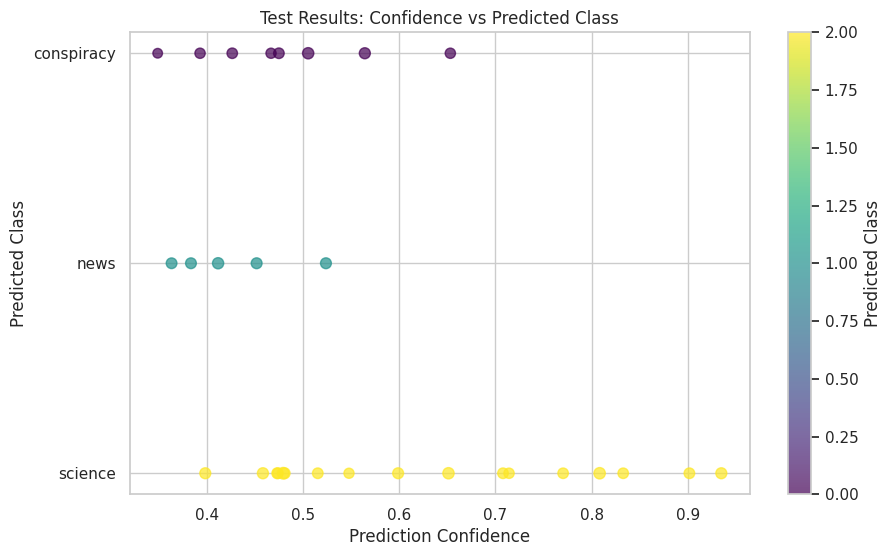

In [35]:

# create interactive test results visualization
def create_interactive_test_results():
    """create visualization of test results using Matplotlib"""
    plt.figure(figsize=(10, 6))

    # Create a scatter plot
    scatter = plt.scatter(
        results_df['confidence'],
        results_df['predicted_class'],
        s=[len(text) for text in test_docs],  # Size based on text length
        c=results_df['predicted_class'].astype('category').cat.codes,  # Color by class
        alpha=0.7,
        cmap='viridis'
    )

    # Add color bar
    plt.colorbar(scatter, label='Predicted Class')

    # Set axis labels and title
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Predicted Class')
    plt.title('Test Results: Confidence vs Predicted Class')

    # Show the plot
    plt.show()

create_interactive_test_results()


In [34]:
# performance summary
print(f"total training examples: {len(X_train)}")
print(f"total test examples: {len(X_test)}")
print(f"model accuracy: {accuracy:.4f}")
print(f"average prediction confidence: {np.mean(results_df['confidence']):.3f}")
print(f"predictions by class: {dict(results_df['predicted_class'].value_counts())}")


total training examples: 1438
total test examples: 360
model accuracy: 0.9278
average prediction confidence: 0.557
predictions by class: {'science': np.int64(17), 'conspiracy': np.int64(8), 'news': np.int64(5)}


## Result

The trained model demonstrated strong performance on the test dataset, achieving an accuracy of 92.78%. Out of 360 test examples, the model's predictions were accurate for approximately 332 instances. The average prediction confidence was 0.557, indicating that while the model is generally accurate, there might be some instances where the confidence in the prediction is moderate. Breaking down the predictions by class shows that among the tested examples, the model predicted 'science' most frequently (17 times), followed by 'conspiracy' (8 times), and least frequently 'news' (5 times). This distribution of predictions on the test set provides insight into how the model performed across the different categories.